In [2]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from time import sleep
from random import shuffle

import numpy as np
from numpy import atleast_2d
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.metrics import adjusted_mutual_info_score
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
from sklearn.neighbors import KDTree

from hdbscan import HDBSCAN

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import cm
import matplotlib.ticker as ticker
import seaborn as sns

from IPython import display
cmap = cm.get_cmap('viridis')
cmap = ListedColormap(sns.xkcd_palette(['denim blue', 'medium green', 'pale red']))

In [3]:
iris = load_iris()
iris.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

In [4]:
features = iris.feature_names
data = pd.DataFrame(data=np.column_stack([iris.data, iris.target]), columns=features + ['label'])
data.label = data.label.astype(int)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   label              150 non-null    int32  
dtypes: float64(4), int32(1)
memory usage: 5.4 KB


In [5]:
data.tail()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),label
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2
149,5.9,3.0,5.1,1.8,2


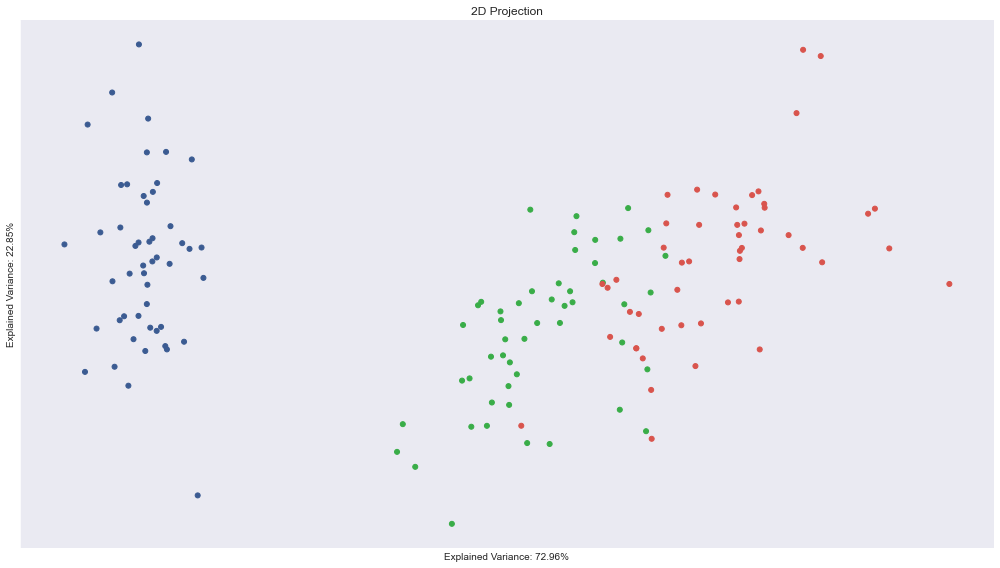

In [7]:
scaler = StandardScaler()
features_standardized = scaler.fit_transform(data[features])
n = len(data)

# reducing Dimensionality by PCA
pca = PCA(n_components=2)
features_2D = pca.fit_transform(features_standardized)
ev1, ev2 = pca.explained_variance_ratio_
ax = plt.figure(figsize=(14, 8)).gca()
ax.set_title('2D Projection')
ax.set_xlabel(f'Explained Variance: {ev1:.2%}')
ax.set_ylabel(f'Explained Variance: {ev2:.2%}')

ax.scatter(*features_2D.T, c=data.label, s=25, cmap=cmap)
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticklabels([])
ax.set_yticks([])
sns.despine()
plt.tight_layout();

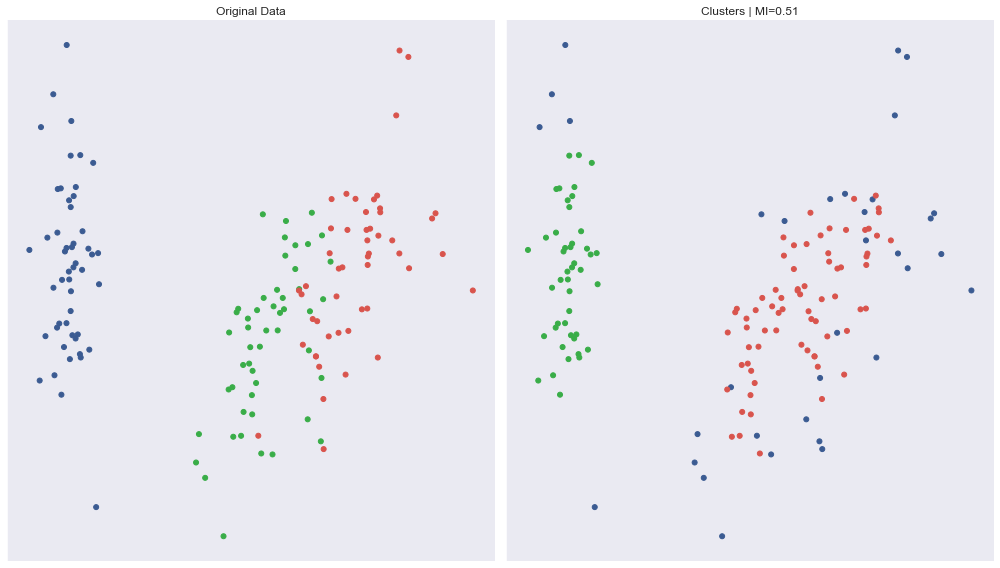

In [8]:
# DBSCAN clustering
clusterer = DBSCAN()
data['clusters'] = clusterer.fit_predict(features_standardized)
fig, axes = plt.subplots(ncols=2, figsize=(14, 8))

labels, clusters = data.label, data.clusters
mi = adjusted_mutual_info_score(labels, clusters)

axes[0].scatter(*features_2D.T, c=data.label, s=25, cmap=cmap)
axes[0].set_title('Original Data')
axes[1].scatter(*features_2D.T, c=data.clusters, s=25, cmap=cmap)
axes[1].set_title('Clusters | MI={:.2f}'.format(mi))

for ax in axes:
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
sns.despine()
fig.tight_layout()

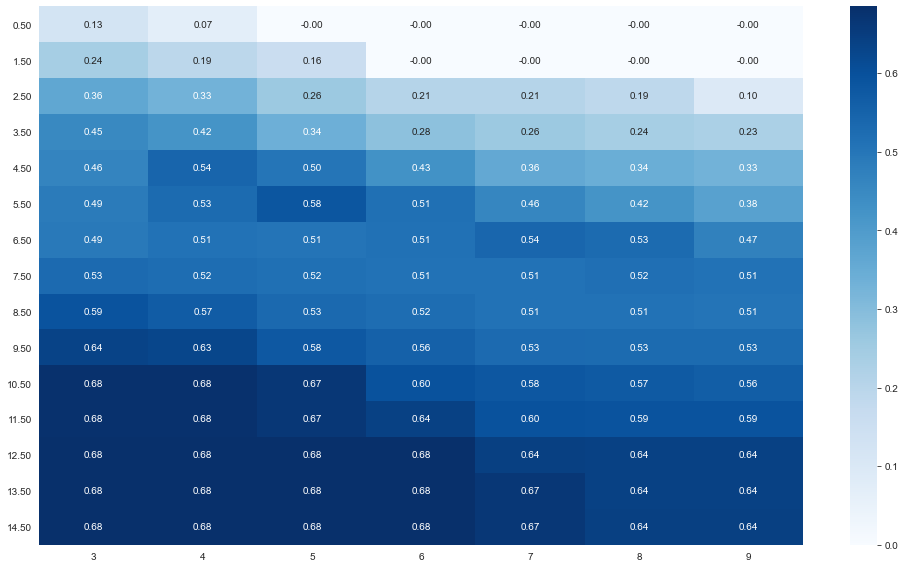

In [9]:
# Compare parameter settings
eps_range = np.arange(.2, .91, .05)
min_samples_range = list(range(3, 10))
labels = data.label
mi = {}
for eps in eps_range:
    for min_samples in min_samples_range:
        clusterer = DBSCAN(eps=eps, min_samples=min_samples)
        clusters = clusterer.fit_predict(features_standardized)
        mi[(eps, min_samples)] = adjusted_mutual_info_score(clusters, labels)
results = pd.Series(mi)
results.index = pd.MultiIndex.from_tuples(results.index)
fig, axes = plt.subplots(figsize=(14, 8))
ax = sns.heatmap(results.unstack(), annot=True, fmt='.2f', cmap='Blues')
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))
plt.tight_layout()

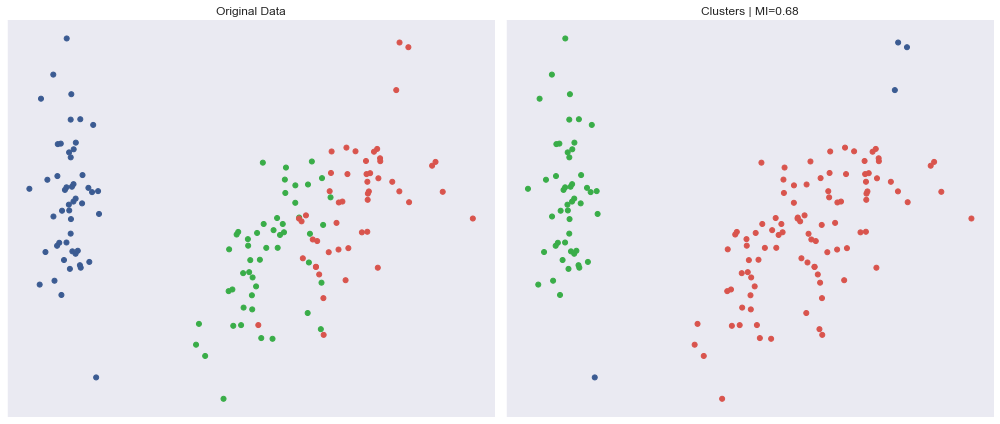

In [10]:
clusterer = DBSCAN(eps=.8, min_samples=5)
data['clusters'] = clusterer.fit_predict(features_standardized)

labels, clusters = data.label, data.clusters
mi = adjusted_mutual_info_score(labels, clusters)

fig, axes = plt.subplots(ncols=2, figsize=(14, 6))
axes[0].scatter(*features_2D.T, c=data.label, s=25, cmap=cmap)
axes[0].set_title('Original Data')
axes[1].scatter(*features_2D.T, c=data.clusters, s=25, cmap=cmap)
axes[1].set_title('Clusters | MI={:.2f}'.format(mi))

for ax in axes:
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
sns.despine()
plt.tight_layout()

In [11]:
# Recursive dbscan
def run_dbscan(point, members):
    members.add(point)
    neighbors = kdtree.query_radius(atleast_2d(data_[point]), eps)[0]
    if len(neighbors) < min_samples:
        return members | set(neighbors)
    else:
        for neighbor in set(neighbors) - set(members):
            members.update(run_dbscan(neighbor, members))
    return members

In [12]:
# Dynamic Plotting
def plot_dbscan(data, assignments, axes, delay=.5):
    for ax in axes:
        ax.clear()
    xmin, ymin = data[['x', 'y']].min()
    xmax, ymax = data[['x', 'y']].max()
    data.plot.scatter(x='x', y='y', c=data.label, cmap=cmap, s=25, title='Original Data', ax=axes[0],
                      colorbar=False)
    plot_data.clusters = plot_data.index.map(assignments.get)
    db_data = data.fillna(0)[data.clusters.notnull()]
    db_data.plot.scatter(x='x', y='y', cmap=cmap, colorbar=False, xlim=(xmin, xmax), ylim=(ymin, ymax),
                         c=db_data.clusters, s=25, title='DBSCAN', ax=axes[1])

    display.display(plt.gcf())
    display.clear_output(wait=True)
    sleep(delay)

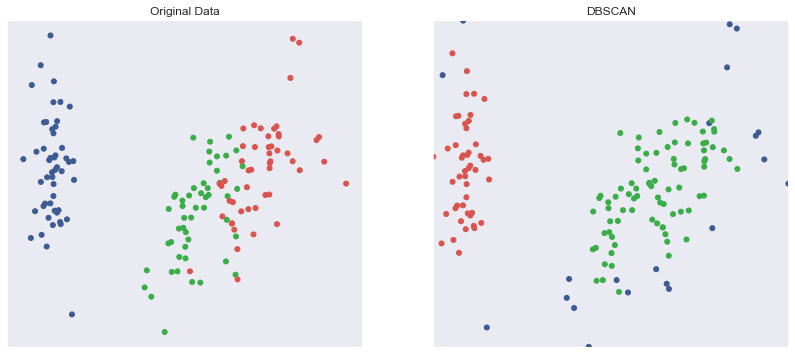

In [13]:
# DBSCAN Execution
eps, min_samples = .6, 5
data_ = features_standardized.copy()
kdtree = KDTree(data_)
to_do = list(range(len(data_)))
shuffle(to_do)
plot_data = pd.DataFrame(data=np.c_[features_2D, labels], columns=['x', 'y', 'label']).assign(clusters=np.nan)
n_clusters = 1
fig, axes = plt.subplots(ncols=2, figsize=(14, 6))
for ax in axes:
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
sns.despine()

assignments = {}
while to_do:
    item = to_do.pop()
    neighbors = kdtree.query_radius(atleast_2d(data_[item, :]), eps)[0]
    if len(neighbors) < min_samples:
        assignments[item] = 0
        plot_dbscan(plot_data, assignments, axes)
    else:
        new_cluster = run_dbscan(item, set())
        to_do = [t for t in to_do if t not in new_cluster]
        for member in new_cluster:
            assignments.update({member: n_clusters})
        n_clusters += 1

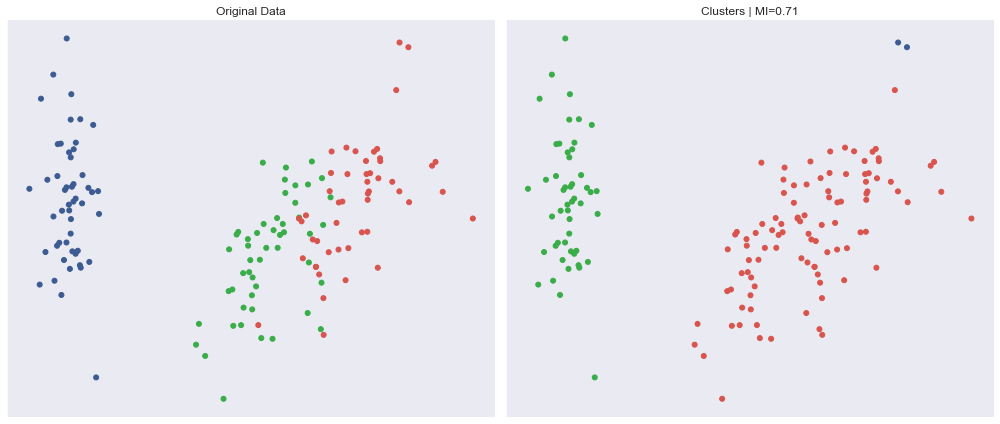

In [14]:
# HDBSCAN
clusterer = HDBSCAN()
data['clusters'] = clusterer.fit_predict(features_standardized)

labels, clusters = data.label, data.clusters
mi = adjusted_mutual_info_score(labels, clusters)
fig, axes = plt.subplots(ncols=2, figsize=(14, 6))

axes[0].scatter(*features_2D.T, c=data.label, s=25, cmap=cmap)
axes[0].set_title('Original Data')
axes[1].scatter(*features_2D.T, c=data.clusters, s=25, cmap=cmap)
axes[1].set_title('Clusters | MI={:.2f}'.format(mi))

for ax in axes:
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
sns.despine()
fig.tight_layout()

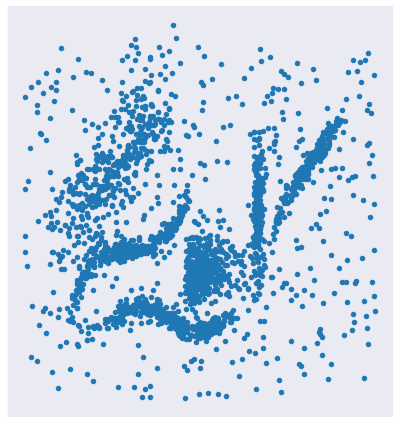

In [16]:
# Alternative Dataset
alternative_data = np.load('data/clusterable_data.npy')
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_aspect('equal')
ax.scatter(*alternative_data.T, s=20)

ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
sns.despine()
fig.tight_layout()

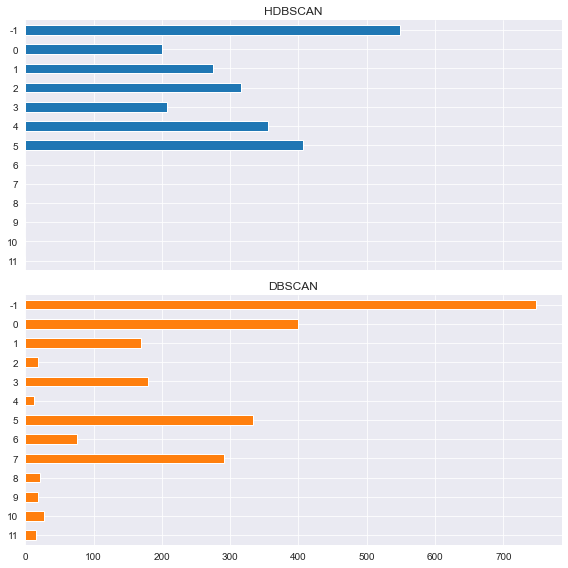

In [17]:
# Compare DBSCAN & HDBSCAN
dbscan = DBSCAN(eps=.02, min_samples=10)
db_clusters = dbscan.fit_predict(alternative_data)
hdbscan = HDBSCAN(min_cluster_size=15, gen_min_span_tree=True)
hdb_clusters = hdbscan.fit_predict(alternative_data)
cluster_sizes = pd.DataFrame({'HDBSCAN': pd.Series(hdb_clusters).value_counts(),
                              'DBSCAN': pd.Series(db_clusters).value_counts()})
cluster_sizes.sort_index(ascending=False).plot.barh(subplots=True, layout=(2, 1), figsize=(8, 8), legend=False)
sns.despine()
plt.tight_layout()